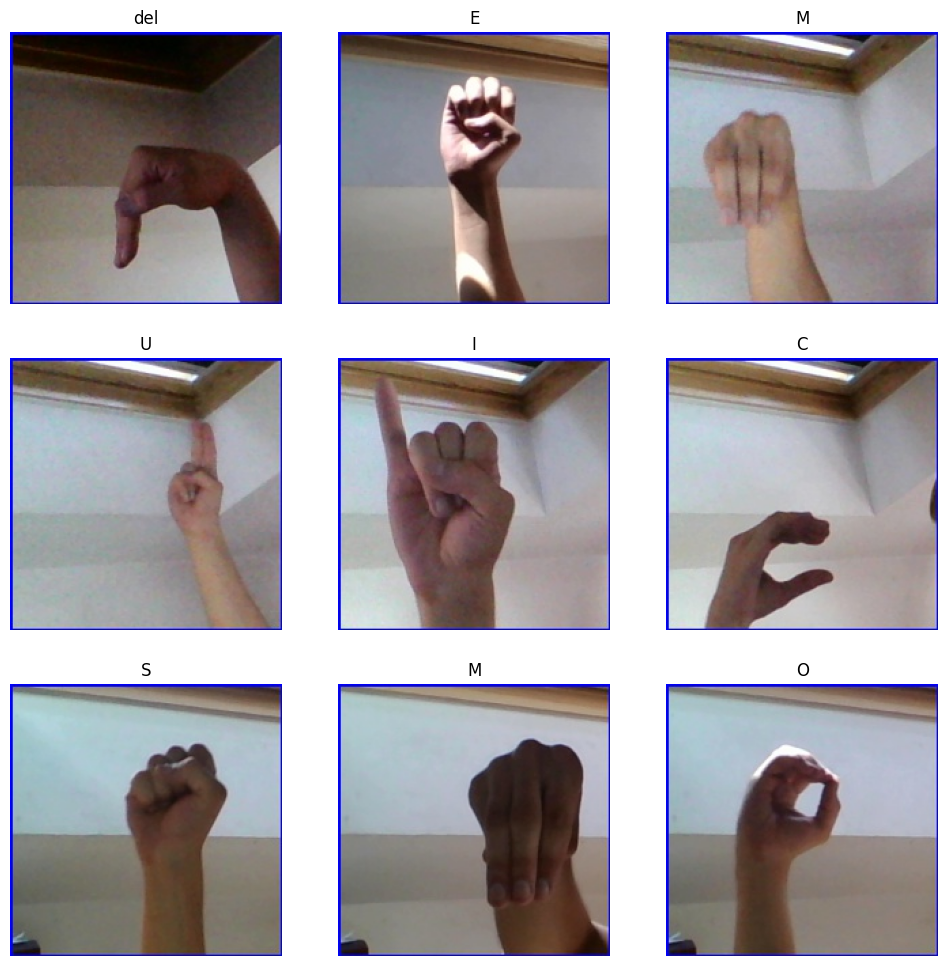

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

dataset_path = "asl_alphabet_train/asl_alphabet_train"

def visualizar_muestras(path):
    classes = os.listdir(path)
    plt.figure(figsize=(12,12))

    for i in range (9):
        clase_random = random.choice(classes)
        img_path = os.path.join(path, clase_random)
        imagenes = os.listdir(img_path)
        img_file = random.choice(imagenes)

        img = mpimg.imread(os.path.join(img_path, img_file))

        plt.subplot(3, 3, i + 1)

        plt.imshow(img)
        plt.title(clase_random)
        plt.axis("off")

    plt.show

visualizar_muestras(dataset_path)

Mano detectada


c:\Users\Jose\Documents\GitHub\Traductor_ASL\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


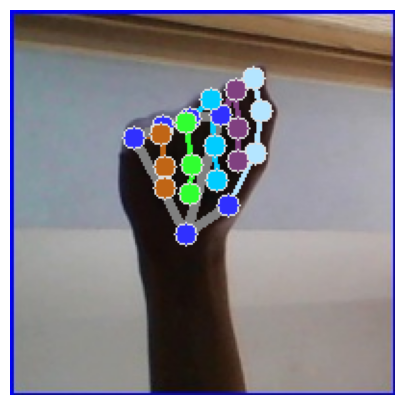

In [11]:
import os
import cv2
import mediapipe as mp
import csv
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline
# Rutas
DATASET_PATH = "asl_alphabet_train/asl_alphabet_train"
OUTPUT_FILE = "hand_landmarks.csv"


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)


# Pequeña prueba para ver si detecta el gesto
test_path = os.path.join(DATASET_PATH, "A")
test_image_name = os.listdir(test_path)[0]
img = cv2.imread(os.path.join(test_path, test_image_name))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = hands.process(img_rgb)

if results.multi_hand_landmarks:
    print("Mano detectada")
    #Puntos sobre la imagen
    annotated_image = img_rgb.copy()
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    
    plt.figure(figsize=(5,5))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()
else:
    print("No se detectó mano.")

In [ ]:
def create_csv_dataset():
    
    header = ['label']
    for i in range(21):
        header.extend([f'x{i}', f'y{i}', f'z{i}'])
    
    
    with open(OUTPUT_FILE, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        classes = sorted(os.listdir(DATASET_PATH))
        
        # Barra de progreso 
        for class_name in tqdm(classes, desc="Procesando Clases"):
            class_path = os.path.join(DATASET_PATH, class_name)
            
            if not os.path.isdir(class_path):
                continue
            
            images = os.listdir(class_path)
            
            # Procesar cada imagen de la clase actual
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                

                try:
                    img = cv2.imread(img_path)
                    if img is None: continue
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    results = hands.process(img_rgb)
                    
                    if results.multi_hand_landmarks:
                        for hand_landmarks in results.multi_hand_landmarks:
                            row = [class_name]
                            for lm in hand_landmarks.landmark:
                                row.extend([lm.x, lm.y, lm.z])
                            writer.writerow(row)
                except Exception as e:
                    print(f"Error en {img_name}: {e}")

    print(f"Archivo guardado como: {OUTPUT_FILE}")


create_csv_dataset()

Procesando Clases:   0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv(OUTPUT_FILE)
print(f"Dataset: {df.shape}")
df.head()

Dataset: (66271, 64)


,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,A,0.455067,0.583699,-6.535676e-07,0.569868,0.507310,-0.034268,0.639892,0.374766,-0.041254,...,-0.030896,0.391800,0.323448,-0.071388,0.404980,0.408848,-0.056392,0.403410,0.461150,-0.029736
1,A,0.484679,0.614140,-8.086669e-07,0.602149,0.543908,-0.025801,0.676200,0.407447,-0.030648,...,-0.038051,0.433377,0.362129,-0.071387,0.446721,0.449887,-0.059596,0.444694,0.504648,-0.038167
2,A,0.723536,0.674143,-6.064619e-07,0.796618,0.617817,-0.031210,0.847895,0.513116,-0.036454,...,-0.008459,0.623256,0.453566,-0.038393,0.630426,0.509675,-0.031511,0.640671,0.555747,-0.014595
3,A,0.713198,0.752710,-4.978732e-07,0.830028,0.651182,-0.042244,0.897471,0.498115,-0.055669,...,-0.049523,0.604026,0.449111,-0.108968,0.632724,0.545299,-0.094273,0.638130,0.612068,-0.063283
4,A,0.718176,0.761456,-4.897136e-07,0.834095,0.666670,-0.041103,0.904353,0.504428,-0.052254,...,-0.054005,0.610919,0.459860,-0.114432,0.639494,0.556237,-0.101240,0.648893,0.624645,-0.071275


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Cargar el dataset recien creado
df = pd.read_csv('hand_landmarks.csv')


X = df.iloc[:, 1:].values 
y_str = df.iloc[:, 0].values 

# Convertir letras a números 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_str)
y_categorical = to_categorical(y_encoded) # One-Hot Encoding

# Guardar las clases para usarlas luego
classes = encoder.classes_
np.save('classes.npy', classes) 
print(f"Clases detectadas: {classes}")


X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Red neuronal
model = models.Sequential([
    
    layers.Input(shape=(63,)),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(len(classes), activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    X_train, y_train,
    epochs=50,             
    batch_size=32,         
    validation_data=(X_test, y_test),
    callbacks=[
        
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


model.save('traductor_sena.keras') 
print("Modelo guardado")

Clases detectadas: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']
Epoch 1/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6163 - loss: 1.3341 - val_accuracy: 0.8994 - val_loss: 0.4144
Epoch 2/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8796 - loss: 0.4252 - val_accuracy: 0.9568 - val_loss: 0.2392
Epoch 3/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9179 - loss: 0.2982 - val_accuracy: 0.9539 - val_loss: 0.2020
Epoch 4/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9315 - loss: 0.2438 - val_accuracy: 0.9570 - val_loss: 0.1683
Epoch 5/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9405 - loss: 0.2127 - val_accuracy: 0.9700 - val_loss: 0.1425
Epoch 6/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9445 - loss: 0.1966 - val_accuracy: 0.9665 - val_loss: 0.1388
Epoch 7/50
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.94